<h2>Importing libraries</h2>

In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import hashlib
import pyspark.pandas as ps

In [3]:
import pyspark.pandas as ps

In [4]:
# Find the correct version from: 
# https://spark-packages.org/package/graphframes/graphframes

os.environ["PYSPARK_SUBMIT_ARGS"] = (
   "--packages graphframes:graphframes:0.8.2-spark3.2-s_2.12 pyspark-shell"
)
spark = SparkSession.builder.appName("BigData Project - GraphFrames").getOrCreate()

# Alternative:
#!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
#!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.0-s_2.12/graphframes-0.8.2-spark3.0-s_2.12.jar
#spark.sparkContext.addPyFile("graphframes-0.8.2-spark3.2-s_2.12.jar")

In [5]:
from functools import reduce
from pyspark.sql.functions import col, lit, when
from graphframes import *

<h2>Reading data</h2>

In [6]:
# Storing information in Spark DataFrames
#/C:/Users/chrsi/Desktop/GSU/000_Classes/Spring 2022/02_Scalable Data Analytics/Project/01_Data
path = "yelp-dataset"
BUSINESS = "yelp_business.csv"
BUSINESS_ATTRS = "yelp_business.csv"
BUSINESS_HOURS = "yelp_business_attributes.csv"
CHECKINS = "yelp_checkin.csv"
REVIEW = "yelp_review.csv"
TIP = "yelp_tip.csv"
USER = "yelp_user.csv"

# businessDF = ps.read_csv(os.path.join(path,BUSINESS), nrows=100)
# business_attrsDF = ps.read_csv(os.path.join(path,BUSINESS_ATTRS), nrows=100)
# business_hoursDF = ps.read_csv(os.path.join(path,BUSINESS_HOURS), nrows=100)
# checkinDF = ps.read_csv(os.path.join(path,CHECKINS), nrows=100)
reviewDF = ps.read_csv(os.path.join(path,REVIEW), nrows=1000000)
# tipDF = ps.read_csv(os.path.join(path,TIP), nrows=100)
userDF = ps.read_csv(os.path.join(path,USER), nrows=1000000)

In [38]:
businessDF.head(2)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""""""Dental by Design""""""",None,"""""""4855 E Warner Rd","Ste B9""""""",Ahwatukee,AZ,85044,33.3306902,-111.9785992,4.0,22.0,1
1,He-G7vWjzVUysIKrfNbPUQ,"""""""Stephen Szabo Salon""""""",None,"""""""3101 Washington Rd""""""",McMurray,PA,15317,40.2916853,-80.1048999,3.0,11,1.0,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...


In [39]:
business_attrsDF.head(2)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""""""Dental by Design""""""",None,"""""""4855 E Warner Rd","Ste B9""""""",Ahwatukee,AZ,85044,33.3306902,-111.9785992,4.0,22.0,1
1,He-G7vWjzVUysIKrfNbPUQ,"""""""Stephen Szabo Salon""""""",None,"""""""3101 Washington Rd""""""",McMurray,PA,15317,40.2916853,-80.1048999,3.0,11,1.0,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...


In [40]:
reviewDF.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,None,None,None
1,"Staff was very helpful and friendly.""",0,0,0,None,None,None,None,None
2,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,None,None,None
3,We had their beef tartar and pork belly to sta...,None,None,None,None,None,None,None,None
4,A bit outside of downtown montreal but take th...,0,0,0,None,None,None,None,None


In [41]:
print(type(userDF))

<class 'pyspark.pandas.frame.DataFrame'>


In [42]:
userDF.head()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,3.70,0,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,2.00,0,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,None,0,0,0,0,None,4.67,0,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,None,0,0,0,0,None,4.67,0,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,None,4,0,0,0,None,3.45,0,0,0,0,0,0,0,0,0,1,0


<h2>GraphFrame implementation</h2>
<br>
GraphFrames will help us quantify the influence each user has, measured by the number of direct and indirect connections they have<br>

In [53]:
edges = []
for ind, row in userDF.iterrows():
    if row["friends"] != None:
        for friend in row["friends"].split():
            edges.append((row["user_id"], friend.replace(",", ""), "friend"))

In [ ]:
edges_ = spark.createDataFrame(edges, ["src", "dst", "relationship"])

In [ ]:
verts = []
for ind, row in userDF.iterrows():
    verts.append((row["user_id"], row["name"], row["yelping_since"]))

In [ ]:
vertices = spark.createDataFrame(verts, ["id", "name", "member_since"])

In [ ]:
vertices.show()

In [ ]:
edges_.show(200)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 62614)
Traceback (most recent call last):
  File "/Users/patrickkelly/opt/anaconda3/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/patrickkelly/opt/anaconda3/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/patrickkelly/opt/anaconda3/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/patrickkelly/opt/anaconda3/lib/python3.8/socketserver.py", line 720, in __init__
    self.handle()
  File "/Users/patrickkelly/opt/anaconda3/lib/python3.8/site-packages/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/Users/patrickkelly/opt/anaconda3/lib/python3.8/site-packages/pyspark/accumulators.py", line 235, in poll
    if 

In [24]:
g = GraphFrame(vertices, edges_)

In [25]:
import networkx as nx
from graphframes import GraphFrame

def PlotGraph(edge_list, n=20):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(n):
        Gplot.add_edge(row['src'],row['dst'])

    #plt.subplot(121)
    nx.draw(Gplot, with_labels=True)

In [52]:
PlotGraph(edges_, n=20)

In [27]:
# Run PageRank
results = g.pageRank(resetProbability=0.15, maxIter=10)

In [29]:
results.vertices.select("id", "pagerank")\
.join(vertices, on="id").orderBy("pagerank", ascending=False)\
.show(20)

+--------------------+------------------+--------+------------+
|                  id|          pagerank|    name|member_since|
+--------------------+------------------+--------+------------+
|JJ-aSuM4pCFPdkfoZ...|1.0000000000000002|   Chris|  2013-09-24|
|uUzsFQn_6cXDh6rPN...|1.0000000000000002|   Tiffy|  2017-03-02|
|mBneaEEH5EMyxaVyq...|1.0000000000000002|    Mark|  2015-03-13|
|W5mJGs-dcDWRGEhAz...|1.0000000000000002|  Evelyn|  2016-09-08|
|4E8--zUZO1Rr1IBK4...|1.0000000000000002|    Lisa|  2012-07-16|
|Ob-2oGBQ7rwwYwUvh...|1.0000000000000002|       B|  2012-05-01|
|JaTVvKsBl0bHHJEpE...|1.0000000000000002|   Peter|  2013-03-23|
|Ykj0DVsz0c6rX9ghj...|1.0000000000000002| Colleen|  2010-10-10|
|kmyEPfKnHQJdTceCd...|1.0000000000000002|       A|  2012-10-16|
|H54pA7YHfjl8IjhHA...|1.0000000000000002|    Chad|  2010-06-25|
|WRae-wZkpRoxMrgJd...|1.0000000000000002|    Mike|  2017-11-29|
|Mmv5fPxbF8XEMN4EP...|1.0000000000000002|   Chris|  2016-06-24|
|moJE85Sfg7Itd3-iI...|1.0000000000000002

In [30]:
# Run triangleCount 
results = g.triangleCount()

In [33]:
results.select("id", "count").show(20)

+--------------------+-----+
|                  id|count|
+--------------------+-----+
|kmyEPfKnHQJdTceCd...|    0|
|W5mJGs-dcDWRGEhAz...|    0|
|Mmv5fPxbF8XEMN4EP...|    0|
|JJ-aSuM4pCFPdkfoZ...|    0|
|mBneaEEH5EMyxaVyq...|    0|
|4E8--zUZO1Rr1IBK4...|    0|
|Ykj0DVsz0c6rX9ghj...|    0|
|H54pA7YHfjl8IjhHA...|    0|
|WRae-wZkpRoxMrgJd...|    0|
|JaTVvKsBl0bHHJEpE...|    0|
|uUzsFQn_6cXDh6rPN...|    0|
|Ob-2oGBQ7rwwYwUvh...|    0|
|V--GjQPlTpeWbcB2c...|    0|
|LdqGHXsNQowMrvgTN...|    0|
|jYnkJR3T8yCERXywo...|    0|
|TsgBsn19Wjwpyo81g...|    0|
|GMGZsk1dj043UI3zW...|    0|
|h5ERTYn2vQ1QbjTZv...|    0|
|eMBV7FugCJq7FIvGh...|    0|
|bsRNTZ1osSKjuGpHB...|    0|
+--------------------+-----+
only showing top 20 rows



<h2>Sentiment Analysis</h2>

In [18]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import regex as re
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickkelly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
X = reviewDF.loc[:, ["text", "stars"]]
X = X.dropna(subset = ['text', 'stars']) 
X = X[(X["stars"]==1)  | (X["stars"]==5)]

index = []
for ind, row in X.iterrows():
    try:
        int(row["stars"])
        index.append(ind)
    except:
        pass
    
X = X.loc[index, :]
X.reset_index(inplace=True, drop=True)
y = X['stars']

In [9]:
def preprocessing(row):
    if row["text"] != None:
        text = row["text"]
        text = text.lower()
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        text = regex.sub(' ', text)

        # remove remaining tokens that are not alphabetic
        text = text.split(' ')
        text = [word for word in text if word.isalpha()]

        # remove stop words
        stop = stopwords.words('english')
        text = [x for x in text if x not in stop]
        lemmatizer = WordNetLemmatizer()
        stemmed_text = []
        for word in text:
            stemmed_text.append(lemmatizer.lemmatize(word))

        text = " ".join(stemmed_text)
        row['text'] = text
    else:
        pass
    return row

In [10]:
def extract_features(training_data):
    # TF-IDF BASED FEATURE REPRESENTATION
    cv=TfidfVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english', max_features= 10000,strip_accents='unicode', norm='l2')

    cv.fit_transform(training_data["text"].values)

    train_feature_set=cv.transform(training_data["text"].values)

    return train_feature_set

In [11]:
X = X.apply(preprocessing, axis=1)
X = extract_features(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train.to_numpy())

#Testing our model
nb_predict = nb.predict(X_test)

#Creating the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test.to_numpy(), nb_predict))

print('\n')

#Creating the classification report
print(classification_report(y_test.to_numpy(), nb_predict)) 

[[1 0]
 [1 1]]


              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           5       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



## Spark MLlib

In [32]:
df = spark.read.option("escape","\"").csv('yelp-dataset/yelp_review.csv', sep=',', multiLine = True, header = True).limit(1000000)

In [35]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

import string
import re

# remove non ASCII characters
def strip_non_ascii(data_str):
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)

strip_non_ascii_udf = udf(strip_non_ascii, StringType())

In [36]:
df = df.withColumn('text_stripped',strip_non_ascii_udf(df['text']))
df.show(5)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|       text_stripped|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|Super simple plac...|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|Small unassuming ...|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|Lester's is locat...|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0|Love coming here....|
|L_9BT

In [37]:
def preprocessing(text):
    text = text.lower()
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub(' ', text)

    # remove remaining tokens that are not alphabetic
    text = text.split(' ')
    text = [word for word in text if word.isalpha()]

    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    lemmatizer = WordNetLemmatizer()
    stemmed_text = []
    for word in text:
        stemmed_text.append(lemmatizer.lemmatize(word))

    text = " ".join(stemmed_text)
    
    return text
preprocessing_udf = udf(preprocessing, StringType())

In [38]:
df = df.withColumn('text_clean', preprocessing_udf(df['text_stripped']))
df.show(5)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+--------------------+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|       text_stripped|          text_clean|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+--------------------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|Super simple plac...|super simple plac...|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|Small unassuming ...|small unassuming ...|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|Lester's is locat...|lester located be...|
|IXvOzsEMYtiJI0CAR...|

In [40]:
from pyspark.sql.types import FloatType

from textblob import TextBlob

def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

sentiment_analysis_udf = udf(sentiment_analysis , FloatType())

In [41]:
df  = df.withColumn("sentiment_score", sentiment_analysis_udf(df['text_clean'] ))
df.show(5)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+--------------------+---------------+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|       text_stripped|          text_clean|sentiment_score|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+--------------------+---------------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|Super simple plac...|super simple plac...|     0.32708332|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|Small unassuming ...|small unassuming ...|     0.32083333|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|   

In [42]:
def condition(r):
    if (r >=0.1):
        label = "positive"
    elif(r <= -0.1):
        label = "negative"
    else:
        label = "neutral"
    return label

sentiment_udf = udf(lambda x: condition(x), StringType())

In [43]:
df  = df.withColumn("sentiment_label", sentiment_udf(df['sentiment_score'] ))
df.show(5)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+--------------------+---------------+---------------+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|       text_stripped|          text_clean|sentiment_score|sentiment_label|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+--------------------+---------------+---------------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|Super simple plac...|super simple plac...|     0.32708332|       positive|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|Small unassuming ...|small unassuming ...|     0.32083333|       positive|
|MV3CcKScW05u5LVfF...|bv2

In [44]:
df.groupBy("sentiment_label").count().show()

+---------------+------+
|sentiment_label| count|
+---------------+------+
|       positive|766125|
|        neutral|173140|
|       negative| 60735|
+---------------+------+



In [50]:
df.select(["sentiment_label", "stars"]).show(100)

+---------------+-----+
|sentiment_label|stars|
+---------------+-----+
|       positive|    5|
|       positive|    5|
|       positive|    5|
|        neutral|    4|
|       positive|    4|
|        neutral|    5|
|        neutral|    4|
|       positive|    4|
|       positive|    3|
|       positive|    5|
|        neutral|    4|
|       negative|    3|
|       positive|    1|
|       positive|    3|
|       positive|    5|
|       positive|    4|
|        neutral|    1|
|       positive|    3|
|       positive|    3|
|        neutral|    1|
|       positive|    3|
|        neutral|    4|
|        neutral|    3|
|       positive|    1|
|       negative|    3|
|        neutral|    3|
|       positive|    2|
|       positive|    5|
|       positive|    3|
|       positive|    4|
|       positive|    4|
|       negative|    1|
|        neutral|    4|
|       positive|    4|
|        neutral|    4|
|        neutral|    5|
|       positive|    4|
|       positive|    4|
|        neutral

In [46]:
sent_label = df.groupBy("sentiment_label").count().toPandas()

In [47]:
import matplotlib.pyplot as plt

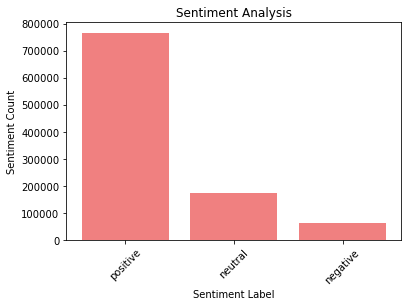

In [49]:
plt.bar(sent_label["sentiment_label"], sent_label['count'], color='lightcoral')
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=45)
plt.title('Sentiment Analysis')
plt.savefig('sentimentAnalysis.png',dpi=300, bbox_inches = "tight")
plt.show()

### Using Spark ML features to calculate features and train a LR

In [70]:
df

DataFrame[review_id: string, user_id: string, business_id: string, stars: string, date: string, text: string, useful: string, funny: string, cool: string, text_clean: string, sentiment_score: float, sentiment_label: string, text_clean_2: string]

In [72]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features")
label_stringIdx = StringIndexer(inputCol = "stars", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(df)
train_df = pipelineFit.transform(df)
train_df.show(5)
"""
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=10)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy"""

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+---------------+---------------+--------------------+--------------------+--------------------+--------------------+-----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|          text_clean|sentiment_score|sentiment_label|        text_clean_2|               words|                  tf|            features|label|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+---------------+---------------+--------------------+--------------------+--------------------+--------------------+-----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|Super simple plac...|     0.25138888|       positive|super simple plac...|[super, simple

'\nfrom pyspark.ml.classification import LogisticRegression\nlr = LogisticRegression(maxIter=10)\nlrModel = lr.fit(train_df)\npredictions = lrModel.transform(val_df)\nfrom pyspark.ml.evaluation import BinaryClassificationEvaluator\nevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")\nevaluator.evaluate(predictions)\n\naccuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())\naccuracy'

### Somesh - PageRank

In [64]:
reviewDF_S = pd.read_csv("C:/Users/chrsi/Desktop/GSU/000_Classes/Spring 2022/02_Scalable Data Analytics/Project/01_Data/yelp_review.csv", nrows=1000000)
businessDF_S = pd.read_csv("C:/Users/chrsi/Desktop/GSU/000_Classes/Spring 2022/02_Scalable Data Analytics/Project/01_Data/yelp_business.csv", nrows=1000000)

In [65]:
vert = pd.merge(left = reviewDF_S[['user_id','business_id']], right = businessDF_S['name'] ,left_on = reviewDF_S['business_id'], right_on = businessDF_S['business_id'])

In [66]:
vert

,key_0,user_id,business_id,name
0,AEx2SYEUJmTxVVB18LlCwA,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,"""Wilensky's"""
1,AEx2SYEUJmTxVVB18LlCwA,xYciRtVZ1PW4IxSX4oJ1aw,AEx2SYEUJmTxVVB18LlCwA,"""Wilensky's"""
2,AEx2SYEUJmTxVVB18LlCwA,5Ymfsf9fAYz-Ds_p0xawVQ,AEx2SYEUJmTxVVB18LlCwA,"""Wilensky's"""
3,AEx2SYEUJmTxVVB18LlCwA,DVOOF0Z627DyrZ4XKQbTgA,AEx2SYEUJmTxVVB18LlCwA,"""Wilensky's"""
4,AEx2SYEUJmTxVVB18LlCwA,5JoKz3mU42Cp906KRXDwJw,AEx2SYEUJmTxVVB18LlCwA,"""Wilensky's"""
...,...,...,...,...
999995,XvVv4rcraQkZlJOHuOdnHQ,ISp-fgSoDaSrDb6MlDkn5w,XvVv4rcraQkZlJOHuOdnHQ,"""Staples"""
999996,rOq4Xiiey0_gqH1O4omV6A,fIzGyMdjdxW86A_gVTQevQ,rOq4Xiiey0_gqH1O4omV6A,"""J Scott Refrigeration & Heating"""
999997,JV7ymvDEg5XCe9EmGlqMDA,fUMmK8l8C7dcZM0swHpTZg,JV7ymvDEg5XCe9EmGlqMDA,"""Delia's Cleaners"""
999998,w8zGQbaNtxlZJrrIEYaGyQ,ZMRsax4wciunMAk8VVdYJQ,w8zGQbaNtxlZJrrIEYaGyQ,"""Kb Films"""


In [67]:
vert.drop(columns = ['key_0'], inplace = True )

In [68]:
edge = vert[['business_id','name']]

In [69]:
vertices = spark.createDataFrame(edge, ["id", "name"])

In [70]:
edges = spark.createDataFrame(vert, ["src", "dst"])

In [71]:
g = GraphFrame(vertices, edges)

In [72]:
results_S = g.pageRank(resetProbability=0.15, maxIter=10)

In [73]:
results_S.vertices.select("id", "pagerank")\
.join(vertices, on="id").orderBy("pagerank", ascending=False)\
.show(10)

+--------------------+-----------------+-------------------+
|                  id|         pagerank|               name|
+--------------------+-----------------+-------------------+
|NmOBomyz63TP9Nn2q...|2.692262250539301|"Smith & Wollensky"|
|NmOBomyz63TP9Nn2q...|2.692262250539301|"Smith & Wollensky"|
|NmOBomyz63TP9Nn2q...|2.692262250539301|"Smith & Wollensky"|
|NmOBomyz63TP9Nn2q...|2.692262250539301|"Smith & Wollensky"|
|NmOBomyz63TP9Nn2q...|2.692262250539301|"Smith & Wollensky"|
|NmOBomyz63TP9Nn2q...|2.692262250539301|"Smith & Wollensky"|
|NmOBomyz63TP9Nn2q...|2.692262250539301|"Smith & Wollensky"|
|NmOBomyz63TP9Nn2q...|2.692262250539301|"Smith & Wollensky"|
|NmOBomyz63TP9Nn2q...|2.692262250539301|"Smith & Wollensky"|
|NmOBomyz63TP9Nn2q...|2.692262250539301|"Smith & Wollensky"|
+--------------------+-----------------+-------------------+
only showing top 10 rows

